<a href="https://colab.research.google.com/github/basilhayek/notebooks/blob/main/Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This advice comes from https://github.com/pygobject/pycairo/issues/39#issuecomment-391830334
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 39 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bio

In [38]:
import math

import cairo
from google.colab import files
from IPython.display import SVG, display, Image


In [4]:
def show_svg(file):
    display(SVG(filename=file))

# https://stackoverflow.com/questions/11854847/how-can-i-display-an-image-from-a-file-in-jupyter-notebook/35061341#35061341
def show_png(file):
    display(Image(filename=file))

In [5]:
from math import atan2, pi

# https://www.codegrepper.com/code-examples/python/calculate+angle+between+3+points+python
def angle(A, B, C):
    Ax, Ay = A[0]-B[0], A[1]-B[1]
    Cx, Cy = C[0]-B[0], C[1]-B[1]
    a = atan2(Ay, Ax)
    c = atan2(Cy, Cx)
    if a < 0: a += pi*2
    if c < 0: c += pi*2
    return (pi*2 + c - a) if a > c else (c - a)

In [48]:
class WeatherPlot():
    def __init__(self):
        WIDTH, HEIGHT = 480, 480
        
        self._surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)

        ctx = cairo.Context(self._surface)
        ctx.scale(WIDTH, HEIGHT)  # Normalizing the canvas

        ctx.set_source_rgb(1, 1, 1)
        ctx.rectangle(0,0, 1, 1)
        ctx.fill()
        self._ctx = ctx
        self._num_hours = None
        self._int_width = None

    def _set_intervals(self, hours):
        self._num_hours = len(hours)
        self._int_width = 1 / self._num_hours

    def _isvalid(self, weather_list):
        if weather_list is None:
            return False
        elif isinstance(weather_list, tuple):
            for x in weather_list:
                if not self._isvalid(x):
                    return False
            return True
        elif not isinstance(weather_list, list):
            return False
        elif len(weather_list) != self._num_hours:
            return False
        else:
            return True


    def _scaled_list(self, l, scale_min=None, scale_max=None):
        if scale_min is None:
            scale_min = min(l)
        if scale_max is None:
            scale_max = max(l)

        s = [x - scale_min for x in l]
        s = [x / (scale_max - scale_min) for x in s]
        return s

    def _add_precip(self, precip_pct, precip_acc):
        scaled_acc = self._scaled_list(precip_acc)
        
        ctx = self._ctx
        for idx, pct in enumerate(precip_pct):
            x0 = idx * self._int_width + 0.1 * self._int_width
            y0 = 1 - pct
            acc = scaled_acc[idx]

            pat = cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
            # First stop: lighter if lower accumulation, blue = 100%
            pat.add_color_stop_rgba(y0, 1 - acc, 1 - acc, 1, 1)
            # Last stop: RGB = 0.8, 0.8, 100
            pat.add_color_stop_rgba(1, 0.8, 0.8, 1, 1) 
        
            ctx.rectangle(x0, y0, 0.9 * self._int_width, 1)  # Rectangle(x0, y0, x1, y1)
            ctx.set_source(pat)
            ctx.fill()

    # Determine where a given point falls relative to the previous / next point
    # calculate bisector?
    def _path_dir():
        pass

    # Place the text
    def _write_text(self, ctx, x, y, text):
        ctx.set_source_rgb(1, 1, 1)
        ctx.select_font_face("Arial", cairo.FONT_SLANT_NORMAL, 
            cairo.FONT_WEIGHT_BOLD)
        ctx.set_font_size(self._int_width / 2.2)

        #(x, y, width, height, dx, dy) = cr.text_extents("ZetCode")
        (_, _, width, height, _, _) = ctx.text_extents(text)
        x = x - width / 2
        y = y + height / 2
        ctx.move_to(x, y)
        ctx.show_text(text)

        ctx.stroke()


    def _add_temps(self, temps):
        scaled_temps = self._scaled_list(temps)

        # Create a buffer above / below the line graph
        scaled_temps = self._scaled_list(scaled_temps, -0.1, 1.1)

        ctx = self._ctx
        ctx.set_source_rgba(1, 0, 0, 1)
        ctx.set_line_width(self._int_width / 20)

        oldy = None
        for idx, temp in enumerate(scaled_temps):
            x0 = idx * self._int_width + self._int_width / 2
            y0 = 1 - temp
            if not oldy is None:
                if y0 > oldy:
                    ctx.set_source_rgba(0.7, 0, 0, 1)
                elif y0 < oldy:
                    ctx.set_source_rgba(1, 0, 0, 1)
                else:
                    ctx.set_source_rgba(0.4, 0, 0, 1)
                ctx.line_to(x0, y0)
                ctx.stroke()
            ctx.move_to(x0, y0)
            oldy = y0


        ctx.stroke()

        
        min_temp = min(temps)
        max_temp = max(temps)
        for idx, temp in enumerate(temps):
            if idx == 0 or idx == len(temps) -1 or temp in [min_temp, max_temp]:
                x0 = idx * self._int_width + self._int_width / 2
                y0 = 1 - scaled_temps[idx]
                #ctx.move_to(x0, y0)
                #ctx.show_text("{}".format(temp))
                ctx.set_source_rgba(0.7,0,0,1)
                ctx.arc(x0, y0, self._int_width / 2, 0, 2*math.pi)
                ctx.fill()
                self._write_text(ctx, x0, y0, "{}".format(temp))



    def draw_weather(self, hours, temps=None, precip_pct=None, precip_acc=None):
        self._set_intervals(hours)

        if self._isvalid((precip_pct, precip_acc)): 
            self._add_precip(precip_pct, precip_acc)
        if self._isvalid(temps):
            self._add_temps(temps)

        self._surface.write_to_png("weather.png")
        show_png("weather.png")

    



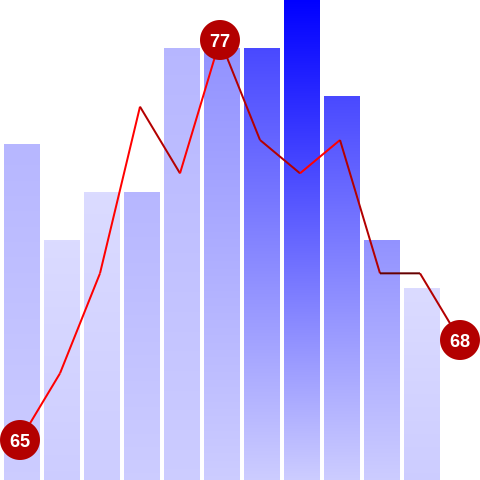

In [49]:
wp = WeatherPlot()
rain_pct = [0.7, 0.5, 0.6, 0.6, 0.9, 0.9, 0.9, 1, 0.8, 0.5, 0.4, 0]
rain_acc = [0.02, 0.01, 0.01, 0.02, 0.02, 0.03, 0.05, 0.07, 0.05, 0.03, 0.01, 0]
temps = [65, 67, 70, 75, 73, 77, 74, 73, 74, 70, 70, 68]

wp.draw_weather([1,2,3,4,5,6,7,8,9,10,11,12], temps, rain_pct, rain_acc)